In [829]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from typing import Dict, List, Tuple

In [11]:
def linear(in_array: np.ndarray, weight: np.ndarray, bias: np.ndarray) -> np.ndarray:
    r"""
    linear transformation: y = xW^T + b

    Args:
        in_array: input array
        weight: input weight
        bias: input bias

    Shapes:
        - Input: (N, in_features)
        - Weight: (out_features, in_features)
        - Bias: (out_features)
        - Output: (N, out_features)
    """

    assert weight.shape[-1] == in_array.shape[-1], "ERR : input and weight dimensions not matched."

    return np.matmul(in_array, weight.T) + bias

In [823]:
def poly(in_array: np.ndarray, weight: np.ndarray, poly_deg: int=3) -> Tuple:
    """
    poly transformation: y = \sum_{i=0}^{n} a_ix^i

    Args:
        in_array: input array
        weight: coefficients in transformation
        poly_deg: the degree of polynomial

    Shapes:
        - Input: (N, in_features)
        - Weight: (depth, )
    """
    poly = PolynomialFeatures(poly_deg)
    base_items = poly.fit_transform(in_array)
    assert base_items.shape[-1] == weight.shape[-1], "shape of weight mismatches with polynomial shape."
    res = np.sum(base_items * weight, axis=1, keepdims=True)

    return res, base_items

def get_poly_dim(num_features: int, poly_deg: int) -> int:
    """test on simple polynomial to check the number of items """
    arr_test = np.zeros([1, num_features])
    poly = PolynomialFeatures(poly_deg)
    return poly.fit_transform(arr_test).shape[-1]


In [34]:
class Module(object):
    def __init(self):
        pass

    def __call__(self):
        return

In [47]:
def regression_initializer(size: Tuple, cate: str='normal') -> Dict:
    """initialize list with size `length`,default to `normal` """
    assert size is not None, "size is None."

    cate_type = cate.lower()
    initial_list = ['normal', 'uniform']
    assert cate_type in initial_list, NotImplemented

    if cate == 'normal':
        return {
            'W': np.random.normal(loc=0., scale=1., size=size),
            'b': np.random.normal(loc=0., scale=1., size=size[0])
        }
    elif cate == 'uniform':
        a = 1. / size[-1]
        return {
            'W': np.random.uniform(low=-a, high=a, size=size),
            'b': np.random.normal(loc=0., scale=1., size=size[0])
        }
    else:
        assert NotImplemented

In [318]:
def mean_squared_error(y_pred: np.ndarray, y_std: np.ndarray, n: int):
    """Mean Squared Error, a.k.a MSE"""
    return np.sum((y_pred - y_std)**2) / n

def loss_fn(cate: str='mse'):
    """loss functions"""
    if cate=='mse':
        return mean_squared_error
    else:
        return NotImplemented

In [185]:
def SGD(dw: np.ndarray, db: np.ndarray, lr: int, weight: np.ndarray, bias: np.ndarray) -> Dict:
    """Stochastic Gradient Descent"""
    return {
        'weight_updated': weight - lr * dw,
        'bias_updated': bias - lr * db
    }

def optimizer(cate: str='SGD'):
    """optimizers"""
    if cate == 'SGD':
        return SGD
    else:
        return NotImplemented


In [757]:
class LinearRegression(Module):
    """
    linear transformations: y = xW^T + b,
    initializer default to `normal`,


    Args:
        in_array: feature array

    Shapes:
        in_array: (N, in_features)
        out_array: (N, )
    """
    def __init__(self, in_array: np.ndarray,
                 initializer_type: str='normal',
                 loss_fn_type: str='mse',
                 lr: float=0.001,
                 optimizer_type: str='SGD'):
        # NOTICE: check in_array for batch case
        super().__init__()
        self.in_array = in_array
        self.batch_size = in_array.shape[0]
        self.in_features = in_array.shape[-1]
        self.out_features = 1
        self.lr = lr
        self.optimizer = optimizer(optimizer_type)
        self.initial = regression_initializer((self.out_features,
                                               self.in_features),
                                               initializer_type)
        self.weight = self.initial['W']
        self.bias = self.initial['b']

        self.loss_fn = loss_fn(loss_fn_type)
        self.loss = 99999

        self.dw = 0
        self.db = 0

        self.y_pred = np.array([])

    def forward(self) -> np.ndarray:
        self.y_pred = linear(self.in_array, self.weight, self.bias)
        return self.y_pred

    def loss_reg(self, y_std):
        self.loss = self.loss_fn(self.y_pred, y_std, self.batch_size)

    def backward(self, y_std):
        diff = self.y_pred - y_std
        self.dw = (1. / self.batch_size) * np.sum(self.in_array * diff, axis=0)
        self.db = (1. / self.batch_size) * np.sum(diff)

    def step(self):
        param_updated = self.optimizer(self.dw, self.db, self.lr, self.weight, self.bias)
        self.weight = param_updated['weight_updated']
        self.bias = param_updated['bias_updated']

    def print_params(self):
        # print(f"weight: {self.weight} \nbias: {self.bias} \nloss: {self.loss}")
        print(f"loss: {self.loss}")

    def __name__(self):
        return "Linear Regression Model"


In [867]:
class PolyRegression(Module):
    """
    Polynomial transformations: y = xW^T + b,
    initializer default to `normal`,


    Args:
        in_array: feature array

    Shapes:
        in_array: (N, in_features)
        out_array: (N, )
    """
    def __init__(self, in_array: np.ndarray,
                 initializer_type: str='normal',
                 loss_fn_type: str='mse',
                 lr: float=0.00001,
                 optimizer_type: str='SGD',
                 poly_deg: int=3):
        # NOTICE: check in_array for batch case
        super().__init__()
        self.in_array = in_array
        self.batch_size = in_array.shape[0]
        self.in_features = in_array.shape[-1]
        self.out_features = 1
        self.lr = lr
        self.poly_deg = poly_deg
        self.optimizer = optimizer(optimizer_type)
        # for initialization in the view of math, check out : https://math.stackexchange.com/questions/2928712/number-of-elements-in-polynomial-of-degree-n-and-m-variables
        self.weight_dim = get_poly_dim(self.in_features, poly_deg)
        self.initial = regression_initializer((self.out_features,
                                               self.weight_dim),
                                               initializer_type)
        self.weight = self.initial['W']

        self.loss_fn = loss_fn(loss_fn_type)
        self.loss = 99999

        self.dw = 0

        self.cache_poly_matrix = np.array([])
        self.y_pred = np.array([])

    def forward(self) -> np.ndarray:
        self.y_pred, self.cache_poly_matrix = poly(self.in_array,
                                                   self.weight,
                                                   self.poly_deg)
        return self.y_pred

    def loss_reg(self, y_std):
        self.loss = self.loss_fn(self.y_pred, y_std, self.batch_size)

    def backward(self, y_std):
        diff = self.y_pred - y_std
        self.dw = (2. / self.batch_size) * np.sum(diff * self.cache_poly_matrix, axis=0)

    def step(self):
        param_updated = self.optimizer(self.dw, 0, self.lr, self.weight, 0)
        self.weight = param_updated['weight_updated']

    def print_params(self):
        # print(f"weight: {self.weight} \nbias: {self.bias} \nloss: {self.loss}")
        print(f"loss: {self.loss}")

    def __name__(self):
        return "Polynomial Regression Model"


In [819]:
def training(model, epochs, labels):
    result = {}

    for epoch in range(epochs):
        model.forward()
        model.backward(labels)
        model.loss_reg(labels)
        model.step()
        print(f"Epoch: {epoch}", end=" ")
        model.print_params()

    result['name'] = model.__class__.__name__
    result['weight'] = model.weight
    # result['bias'] = model.bias
    result['loss'] = model.loss

    return result

## Test

In [687]:
def synthetic_linear_data(w,b,num_examples):
    """ 生成 y = Xw + b + 噪声。"""
    X = np.random.normal(0,1,(num_examples,len(w[0])))
    y = np.matmul(X,w.T) + b
    y += np.random.normal(0,0.01,y.shape) # 均值为0，方差为1
    return X, y.reshape((-1,1))

true_w = np.array([[1.2, 3, 5, 6, 7]])
true_b = [[4.2]]
features, labels = synthetic_linear_data(true_w,true_b,1000)

In [794]:
linear_reg = LinearRegression(features, lr=0.0000001)
training_res = training(linear_reg, 1000, labels)

Epoch: 0 loss: 149.70353936457153
Epoch: 1 loss: 149.70351087339418
Epoch: 2 loss: 149.70348238222232
Epoch: 3 loss: 149.70345389105583
Epoch: 4 loss: 149.70342539989485
Epoch: 5 loss: 149.7033969087393
Epoch: 6 loss: 149.70336841758922
Epoch: 7 loss: 149.70333992644458
Epoch: 8 loss: 149.70331143530544
Epoch: 9 loss: 149.7032829441717
Epoch: 10 loss: 149.70325445304343
Epoch: 11 loss: 149.70322596192062
Epoch: 12 loss: 149.70319747080322
Epoch: 13 loss: 149.7031689796913
Epoch: 14 loss: 149.70314048858484
Epoch: 15 loss: 149.70311199748383
Epoch: 16 loss: 149.70308350638825
Epoch: 17 loss: 149.70305501529816
Epoch: 18 loss: 149.7030265242135
Epoch: 19 loss: 149.70299803313426
Epoch: 20 loss: 149.70296954206057
Epoch: 21 loss: 149.70294105099225
Epoch: 22 loss: 149.70291255992942
Epoch: 23 loss: 149.702884068872
Epoch: 24 loss: 149.70285557782006
Epoch: 25 loss: 149.7028270867736
Epoch: 26 loss: 149.70279859573253
Epoch: 27 loss: 149.70277010469698
Epoch: 28 loss: 149.70274161366683
Ep

In [845]:
training_res

{'name': 'LinearRegression',
 'weight': array([[ 0.78295004,  0.24211752, -1.91659725,  0.61005795, -0.65543667]]),
 'bias': array([0.33845548]),
 'loss': 149.67507939627575}

In [868]:
def synthetic_poly_data():
    x = np.linspace(0, 1, 100)
    y = np.sin(5 * x) + 0.1 + np.random.randn(len(x)) * 0.1
    return x, y

syn_poly_data = synthetic_poly_data()
poly_features = syn_poly_data[0][:, np.newaxis]
poly_labels = syn_poly_data[1][:, np.newaxis]

In [887]:
poly_reg = PolyRegression(poly_features, lr=0.1, poly_deg=10)
poly_training_res = training(poly_reg, 12000, poly_labels)

Epoch: 0 loss: 0.8632323430615952
Epoch: 1 loss: 0.6426381503328248
Epoch: 2 loss: 0.5192799515067253
Epoch: 3 loss: 0.4404727635355489
Epoch: 4 loss: 0.3839445786291737
Epoch: 5 loss: 0.33998687678731954
Epoch: 6 loss: 0.3041243857218717
Epoch: 7 loss: 0.2740984805148776
Epoch: 8 loss: 0.24862039329286695
Epoch: 9 loss: 0.22685132347857084
Epoch: 10 loss: 0.20818176801755142
Epoch: 11 loss: 0.19213459021952395
Epoch: 12 loss: 0.178319743195794
Epoch: 13 loss: 0.16641096691475432
Epoch: 14 loss: 0.1561321774871525
Epoch: 15 loss: 0.14724841572168856
Epoch: 16 loss: 0.13955916628852968
Epoch: 17 loss: 0.13289307787969137
Epoch: 18 loss: 0.1271036248978375
Epoch: 19 loss: 0.1220654692676262
Epoch: 20 loss: 0.11767137801360684
Epoch: 21 loss: 0.11382959858964589
Epoch: 22 loss: 0.11046161855302863
Epoch: 23 loss: 0.10750025106544885
Epoch: 24 loss: 0.1048879979144393
Epoch: 25 loss: 0.10257564944907281
Epoch: 26 loss: 0.10052108698684553
Epoch: 27 loss: 0.09868825834712089
Epoch: 28 loss:

In [870]:
poly_training_res

{'name': 'PolyRegression',
 'weight': array([[ 0.28955961, -0.67094639, -1.09431956,  0.45332229, -0.23413665,
         -0.65399165, -0.01811089,  1.48836962,  1.65954103,  0.75829419,
          0.10826999]]),
 'loss': 1.014896873707193}

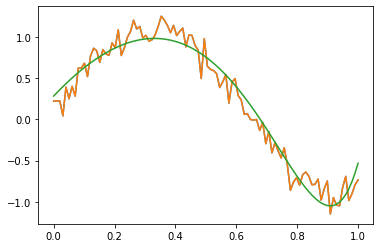

In [888]:
# poly_training_res
plt.plot(poly_features, poly_labels)

def getY_Hat(x, theta):
    # 根据 theta 作为系数，生成多项式函数
    f = np.poly1d(theta)
    return f(x)

plt.plot(poly_features, poly_labels)
plt.plot(poly_features, getY_Hat(poly_features, np.flip(poly_training_res['weight'][0])))

## Authentic Dataset

In [889]:
sheet = pd.read_csv('output_9291044.csv')
sheet

,index,a,e,i,om,w,q,ad,data_arc,n_obs_used,diameter,n,per,ma
0,0,-0.029846,-0.895611,0.035828,-0.871575,-1.045872,0.302371,-0.085269,-0.023760,0.548671,939.400,-0.100997,-0.010812,-1.022562
1,1,-0.027679,1.093829,3.582539,0.031665,1.237434,-0.520651,0.063683,10.280279,13.113797,545.000,-0.107698,-0.010489,-1.193462
2,2,-0.095528,1.436801,0.386203,0.000245,0.639594,-0.812286,0.044314,10.339673,10.788041,246.596,0.111949,-0.020501,-1.433030
3,3,-0.297618,-0.731735,-0.469255,-0.642731,-0.301053,-0.485692,-0.226383,2.486040,14.514957,525.400,0.912062,-0.049169,-0.843764
4,4,-0.157850,0.587956,-0.728912,-0.275048,1.707118,-0.620504,-0.055395,8.850443,3.760430,106.699,0.333305,-0.029528,0.959753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137631,797860,0.234191,0.175758,2.450501,1.355319,-1.565887,0.511487,0.155093,-1.070295,-1.048818,3.793,-0.791726,0.029889,-0.175197
137632,798077,-0.174819,-0.894811,0.182010,0.744511,-0.114080,-0.093109,-0.167225,-0.920349,-1.077345,2.696,0.397162,-0.031957,-0.365503
137633,798189,0.217787,0.967786,1.114461,-0.310050,-0.009712,0.096293,0.211838,-0.994673,-1.053853,2.917,-0.755178,0.027281,-0.082262
137634,799752,0.155458,1.830068,0.600955,1.694918,1.551910,-0.442448,0.242311,-1.097071,-1.087413,3.271,-0.609446,0.017466,-0.071639


In [890]:
sheet.drop('index', axis=1, inplace=True)
label = sheet['diameter']
dia_dropped = sheet.drop('diameter', axis=1)
feature = dia_dropped

# labels & features
label_a = np.array(label)[:1000][:, np.newaxis]
feature_a = np.array(feature)[:1000]

(1000, 1)


## Linear Model

In [765]:
linear_reg_asteroids = LinearRegression(feature_a, lr=0.001)
training_res = training(linear_reg_asteroids, 100, label_a)

Epoch: 0 loss: 8217.379890666087
Epoch: 1 loss: 7790.131723849973
Epoch: 2 loss: 7400.483953428045
Epoch: 3 loss: 7045.118482373708
Epoch: 4 loss: 6721.010045089201
Epoch: 5 loss: 6425.400364150609
Epoch: 6 loss: 6155.774587798047
Epoch: 7 loss: 5909.839806888393
Epoch: 8 loss: 5685.505467791725
Epoch: 9 loss: 5480.865513908709
Epoch: 10 loss: 5294.182103252941
Epoch: 11 loss: 5123.870763005737
Epoch: 12 loss: 4968.486854226227
Epoch: 13 loss: 4826.713231091606
Epoch: 14 loss: 4697.348989246638
Epoch: 15 loss: 4579.29920714525
Epoch: 16 loss: 4471.565592749657
Epoch: 17 loss: 4373.237955686496
Epoch: 18 loss: 4283.486432010897
Epoch: 19 loss: 4201.55439515856
Epoch: 20 loss: 4126.751992527692
Epoch: 21 loss: 4058.450252477078
Epoch: 22 loss: 3996.0757113993336
Epoch: 23 loss: 3939.1055149711447
Epoch: 24 loss: 3887.0629517329403
Epoch: 25 loss: 3839.513380843634
Epoch: 26 loss: 3796.060519223269
Epoch: 27 loss: 3756.3430563665293
Epoch: 28 loss: 3720.031567909168
Epoch: 29 loss: 3686.8

In [740]:
training_res

{'name': 'LinearRegression',
 'weight': array([[ 1.10473113, -0.08566122,  0.79126384, -0.00888531,  0.93087858,
          1.32911977, -0.05107645,  8.52626194,  6.22214325, -2.04837024,
          0.34220255,  1.56961659]]),
 'bias': array([1.30406137]),
 'loss': 271638.75626286486}

## Polynomial Model

In [903]:
linear_reg_asteroids = PolyRegression(feature_a, lr=0.00001, poly_deg=3)
poly_training_res = training(linear_reg_asteroids, 100, label_a)

Epoch: 0 loss: 178222.587639222
Epoch: 1 loss: 88730.01901298095
Epoch: 2 loss: 53987.61232418959
Epoch: 3 loss: 38609.07836542431
Epoch: 4 loss: 30551.20019347055
Epoch: 5 loss: 25588.526623732443
Epoch: 6 loss: 22148.339536472882
Epoch: 7 loss: 19582.921276399597
Epoch: 8 loss: 17584.800043798736
Epoch: 9 loss: 15983.921932673256
Epoch: 10 loss: 14673.793679231127
Epoch: 11 loss: 13582.150860973687
Epoch: 12 loss: 12657.693515887122
Epoch: 13 loss: 11863.10574052501
Epoch: 14 loss: 11170.85771164387
Epoch: 15 loss: 10560.440002244752
Epoch: 16 loss: 10016.444324848479
Epoch: 17 loss: 9527.19564527399
Epoch: 18 loss: 9083.764378753292
Epoch: 19 loss: 8679.248364508536
Epoch: 20 loss: 8308.249070816566
Epoch: 21 loss: 7966.488594146638
Epoch: 22 loss: 7650.529058007194
Epoch: 23 loss: 7357.566619521234
Epoch: 24 loss: 7085.279895957351
Epoch: 25 loss: 6831.718122278894
Epoch: 26 loss: 6595.21834237206
Epoch: 27 loss: 6374.343839281177
Epoch: 28 loss: 6167.838122387062
Epoch: 29 loss: 5

In [904]:
poly_training_res

{'name': 'PolyRegression',
 'weight': array([[ 1.86396275e-01,  9.04133238e-01, -1.89977574e-01,
          3.49076381e-01,  9.77994879e-01, -8.41313650e-01,
         -2.31676640e-01,  7.27497721e-01,  1.62331707e+00,
          4.62461347e-01, -6.91186383e-01, -1.20293457e+00,
          9.78932681e-02,  6.01841698e-01,  4.33366787e-01,
          1.33590556e+00,  3.30690326e-03, -1.76938886e+00,
          1.52812501e+00, -3.29851186e-01,  1.45915055e+00,
         -4.90731721e-02,  3.23598252e-01,  3.88547223e-01,
         -1.66678011e+00, -7.30084855e-01, -9.41917958e-01,
         -2.06816921e+00, -1.47127839e+00, -1.77460277e+00,
          1.96987496e+00, -6.82104546e-02,  1.28872863e+00,
          1.29784572e+00, -1.49469514e+00,  1.40897607e+00,
          5.94351286e-01,  1.65946206e+00,  1.57592012e+00,
          1.00607973e+00,  9.01081098e-01,  3.86310325e-01,
          2.15611234e-01,  1.06044101e-01, -2.91116607e-01,
         -1.47473076e+00,  5.66315869e-01,  1.82229459e+00,
   